## Probit model
---


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as st
from IPython.display import display

The following cell generates data from 

$$
 y_i = \begin{cases}
 1, & \text{with probability}\quad \mu_i; \\
 0, & \text{with probability}\quad 1-\mu_i.
 \end{cases}
$$

$$
 \Phi^{-1}(\mu_i) = 0.5 x_{1i} - 0.5 x_{2i},\quad i=1,\dots,500.
$$

In [2]:
n = 500
rng = np.random.default_rng(seed=99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n, random_state=rng)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n, random_state=rng)
q = st.norm.cdf(0.5*x1 - 0.5*x2)
y = st.bernoulli.rvs(q, random_state=rng)
X = np.stack((np.ones(n), x1, x2), axis=1)

In [3]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
probit_model = pm.Model()
with probit_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Bernoulli('y', p=pm.invprobit(idx), observed=y)
n_draws = 5000
n_chains = 4
n_tune = 1000
with probit_model:
    # trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=rng) # PyMC default sampler (very slow)
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=rng, nuts_sampler='numpyro', progressbar=False) # numpyro (much faster)
results = az.summary(trace, hdi_prob=0.95)
var_names = ['$\\beta_{:d}$'.format(index) for index in range(k)]
results.index = var_names
sim_param = dict([(var, trace.posterior['b'].values[:, :, index]) for index, var in enumerate(var_names)])

In [4]:
display(results)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$\beta_0$,0.049,0.060,-0.067,0.170,0.0,0.0,18454.0,14904.0,1.0
$\beta_1$,0.464,0.064,0.342,0.592,0.0,0.0,17591.0,14328.0,1.0
$\beta_2$,-0.510,0.065,-0.637,-0.383,0.0,0.0,17657.0,14935.0,1.0


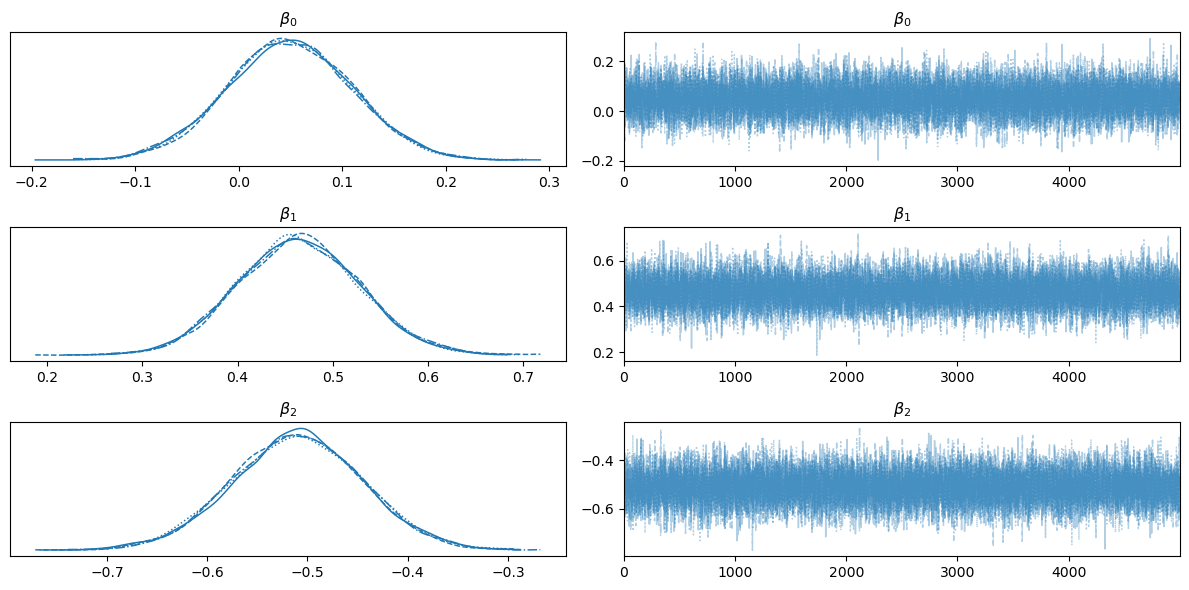

In [5]:
az.plot_trace(sim_param)
plt.tight_layout()
plt.show()

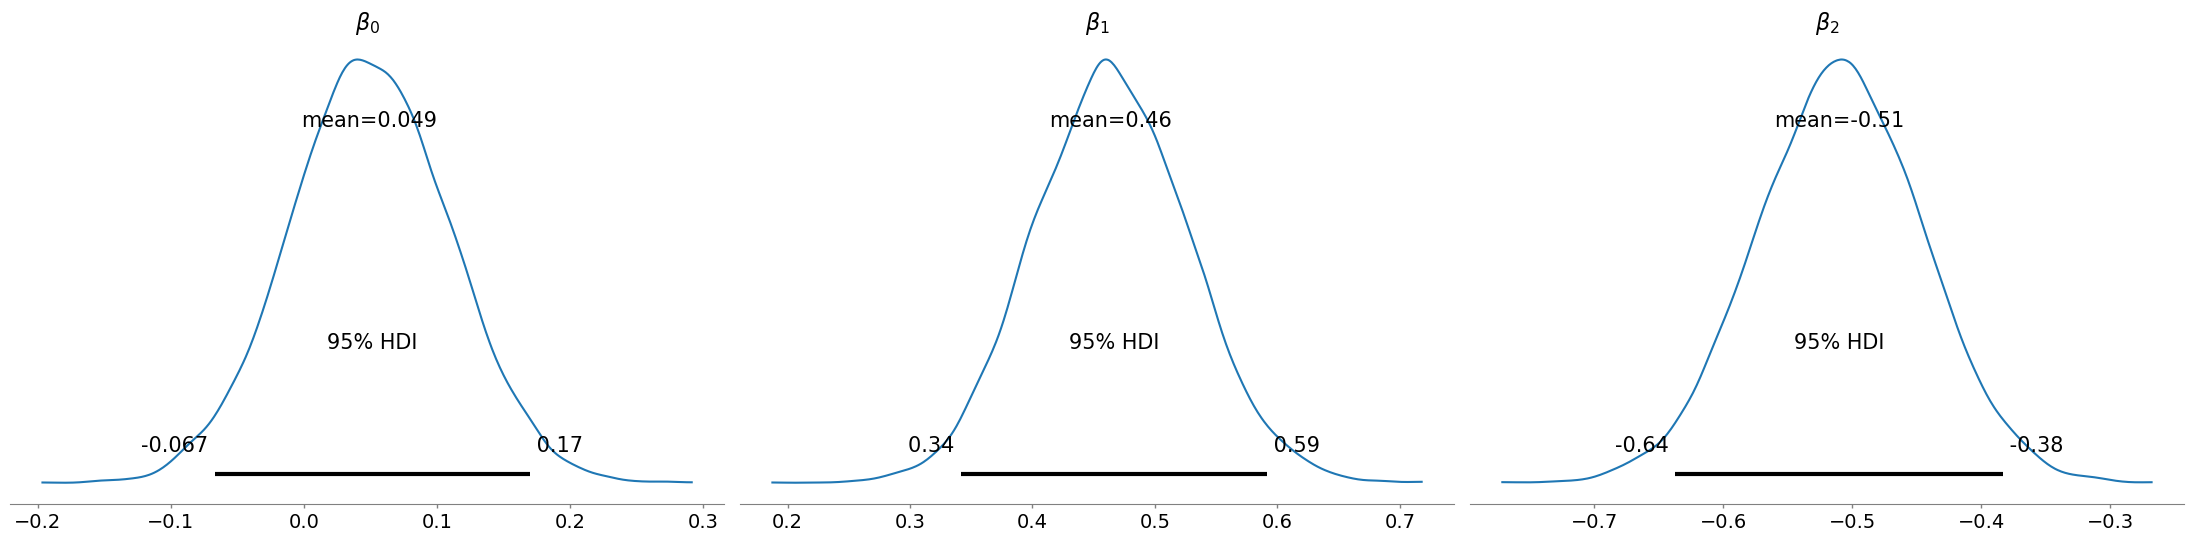

In [6]:
az.plot_posterior(sim_param, kind='kde', point_estimate='mean', hdi_prob=0.95)
plt.tight_layout()
plt.show()